#fake data

The following cell produce random weighted network. For applying this code you may need a adjacency matrix and list of modules assigned to each node.

In [1]:
import pickle as pkl
from sklearn.metrics.cluster import normalized_mutual_info_score
from google.colab import files
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os
import seaborn as sns

<ipython-input-3-adb26931a4fa>:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='Module')


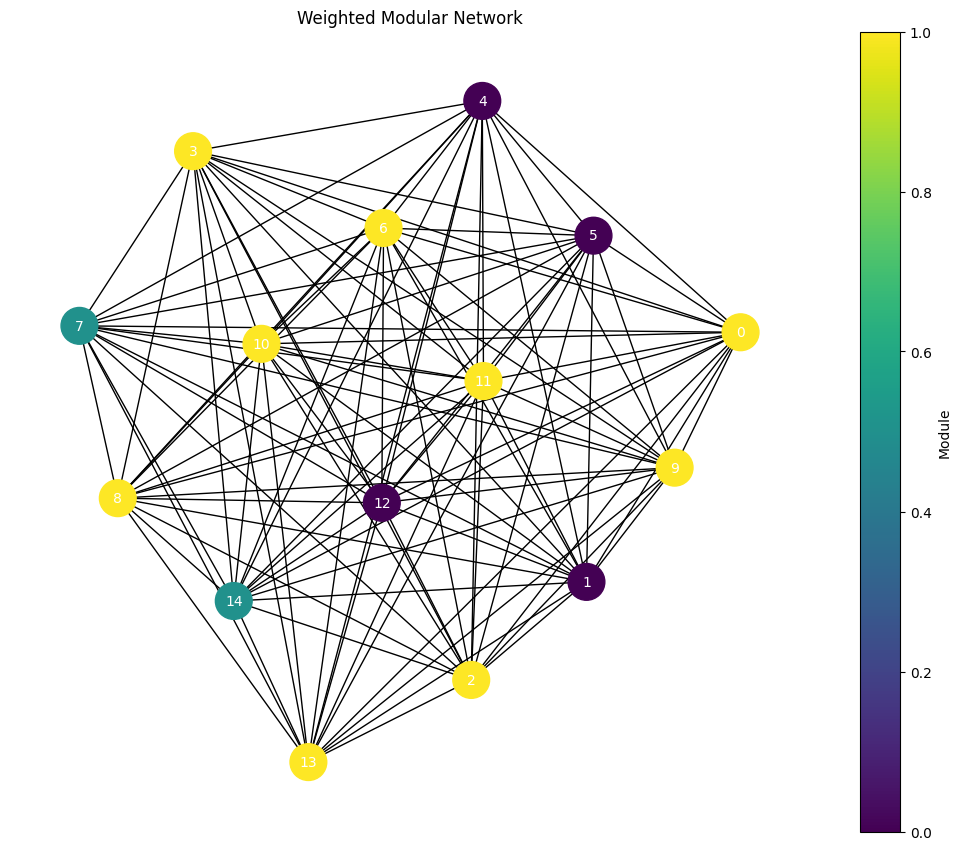

Module assignments for each node:
Node 0: Module 2
Node 1: Module 0
Node 2: Module 2
Node 3: Module 2
Node 4: Module 0
Node 5: Module 0
Node 6: Module 2
Node 7: Module 1
Node 8: Module 2
Node 9: Module 2
Node 10: Module 2
Node 11: Module 2
Node 12: Module 0
Node 13: Module 2
Node 14: Module 1

Adjacency Matrix:
[[0.         0.67019239 0.77427468 0.16365977 0.69354654 0.64170193
  0.75370838 0.23180044 0.2539462  0.39577784 0.4350808  0.49359446
  0.96958744 0.30252705 0.19933361]
 [0.67019239 0.         0.9082129  0.51860343 0.57671429 0.63580266
  0.46293474 0.1158527  0.81731889 0.76995159 0.68441982 0.20676914
  0.39459364 0.59057945 0.61290187]
 [0.77427468 0.9082129  0.         0.45594743 0.09815796 0.5150416
  0.49421572 0.31222581 0.41855633 0.22117515 0.62055461 0.48375274
  0.63889329 0.95016135 0.61804304]
 [0.16365977 0.51860343 0.45594743 0.         0.52168813 0.65428177
  0.61760411 0.73501571 0.60469041 0.32004249 0.54621553 0.56699181
  0.17698702 0.14977869 0.52986705]


In [3]:
# Parameters
num_nodes = 15
num_modules = 3

# Generate random module assignments
np.random.seed(42)  # For reproducibility
module_assignments = np.random.randint(0, num_modules, size=num_nodes)

# Create a random adjacency matrix
# Generate a symmetric matrix with random weights
adj_matrix = np.random.rand(num_nodes, num_nodes)
adj_matrix = (adj_matrix + adj_matrix.T) / 2  # Make it symmetric
np.fill_diagonal(adj_matrix, 0)  # No self-loops

# Create a NetworkX graph from the adjacency matrix
G = nx.from_numpy_array(adj_matrix)

# Plot the network
pos = nx.spring_layout(G)  # Positioning of nodes
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color=module_assignments, cmap='viridis', node_size=700, font_size=10, font_color='white')
plt.title('Weighted Modular Network')
plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='Module')
plt.show()

# Print module assignments
print("Module assignments for each node:")
for node, module in enumerate(module_assignments):
    print(f"Node {node}: Module {module}")

# Print adjacency matrix
print("\nAdjacency Matrix:")
print(adj_matrix)


#Efficiency

normalization: https://arxiv.org/pdf/cond-mat/0204089, weighted version: Complex network measures of brain connectivity: Uses and interpretations.
\
you can check the readme file for more details.

In [4]:
"Larger weights in the fMRI data indicate the higher correlation not longer distance, so you should invers weigts, moreover negative correaltion"
"cause the negative loop and djkestra's algorithm can't find shortest path, so you must seperate negative and positive network(check the readme file)."


#function for deleting negative weight and transforming weights
def dis_metric(adj_matrix):
  a = 10
  adj = np.copy(adj_matrix)
  adj[adj < 0] = 0
  adj = a*np.max(adj) - adj
  return  adj

#function for finding global weighted efficiency, it is not normalized efficiency, for normalization check the readme file.
def global_weighted_efficiency(adj_matrix):
    G = nx.from_numpy_array(adj_matrix)
    path_lengths = dict(nx.all_pairs_dijkstra_path_length(G))
    NR = len(adj_matrix)
    eff = 0
    for i in range(NR):
        for j in range(NR):
            if i != j:
                eff += 1 / path_lengths[i][j]
    return eff

#function for finding subgraph efficiency
def subgraph_measures(adj_matrix, module_assignments):
  adj = dis_metric(adj_matrix)
  G = nx.from_numpy_array(adj)
  module_efficiency = []
  unique_modules = set(module_assignments)
  for module in unique_modules:
      # Extract subgraph for the current module
      nodes_in_module = [i for i, m in enumerate(module_assignments) if m == module]
      subgraph = G.subgraph(nodes_in_module)
      # Calculate global efficiency for the subgraph
      efficiency = global_weighted_efficiency(nx.adjacency_matrix(subgraph).todense())
      module_efficiency += [efficiency]
  return module_efficiency

#Clustering Coefficient

If you don't seperate the negative matrix, it may return complex value.

In [7]:
def subgraph_measures(adj_matrix, module_assignments):
  adj = np.copy(adj_matrix)
  adj[adj < 0] = 0

  G = nx.from_numpy_array(adj)
  unique_modules = set(module_assignments)
  cluster_i = np.zeros(len(unique_modules))

  clusterin_coef = nx.clustering(G, weight='weight')

  for module in unique_modules:
      nodes_in_module = [i for i, m in enumerate(module_assignments) if m == module]
      for j in nodes_in_module:
        cluster_i[module] += clusterin_coef[j]
      cluster_i[module] = cluster_i[module]/len(nodes_in_module)
  return cluster_i

array([0.5001388 , 0.48344564, 0.47937253])

#Communicability

you can check:
1. Estrada E, Hatano N. Communicability in complex networks. Phys Rev E Stat Nonlin Soft
Matter Phys. 2008 Mar;77(3 Pt 2):036111. doi: 10.1103/PhysRevE.77.036111. Epub 2008
Mar 11. PMID: 18517465.
2. Crofts JJ, Higham DJ. A weighted communicability measure applied to complex brain net-
works. J R Soc Interface. 2009 Apr 6;6(33):411-4. doi: 10.1098/rsif.2008.0484. Epub 2009
Jan 13. PMID: 19141429; PMCID: PMC2658663.

In [ ]:
from scipy.linalg import expm

#function for deleting negative weight
def dis_metric(adj_matrix):
  a = 10
  adj = np.copy(adj_matrix)
  adj[adj < 0] = 0
  return  adj

#function for normalizing weights
def D_mat(adj_matrix):
  adj = dis_metric(adj_matrix)
  NR = np.shape(adj)
  d = []
  D = np.zeros((NR,NR))
  for i in range(NR):
    d += [np.sum(adj[i])**(-0.5)]
  for i in range(NR):
    for j in range(NR):
      D[i,j] = d[i]*adj[i,j]*d[j]
  return D


#function for calculating communicability:)
def calculate_communicability(adj_matrix):
  D = D_mat(adj_matrix)
  return expm(D)

#function for resorting the adjacency matrix in order of modules.
def resort(adj, module_assignments):
    new_indices = []
    for m in sorted(set(module_assignments)):
        loc = np.where(np.atleast_1d(module_assignments) == m)[0]
        new_indices.extend(loc)
    new_adj = adj[np.ix_(new_indices, new_indices)]
    return new_adj